## Adversary model

### Load data 
A small section of the Bornholm's district heating network is selected. Olsker, a town between Hasle and Allinge, containing 11 meters. 

In [491]:
#Import import data handing functions
from import_data import *

In [492]:
#List of cities: Aakirkeby, Allinge, Gudhjem, Hasle, Klemensker, Nexo, Ostermarie, Ronne, Svaneke
city='Allinge'
start_date='2023-01-01' #earliest '2022-11-01'
end_date='2023-02-01'
granularity='hourly' #daily or hourly
data = select_data(city, start_date, end_date, granularity)

c:\Users\junes\Desktop\BEOF\DPcodes\import_data.py:54: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df1 = df[df["reading_datetime"] >= start_date][df["reading_datetime"] <= end_date]


In [493]:
#Select meters
meter_keys = ['m1', 'm2', 'm3', 'm4', 'm5', 'm6', 'm7', 'm8', 'm9', 'm10', 'm11']
meter_no = ['78500106', '78181671', '78182030',
            '78181974', '78329899', '78181683',
            '78181976', '78181676', '78181663', 
            '80126750', '78182015']

In [494]:
#Import data in dictionary
set_range = 24*(28) 
meter_data = {meter_keys[i] : data[data['heat_meter_serial_number'] == meter_no[i]][0:set_range] for i in range(0, len(meter_no))}

In [495]:
# Calculate average temperature for all meters
meter_avg_temp = {}
for key, value in meter_data.items():
    supplied_energy = []
    volume = []
    for i in range(1,len(meter_data['m1']['cumulative_supplied_energy_e8'].values)-1):
        supplied_energy.append(meter_data[key]['cumulative_supplied_energy_e8'].values[i]-meter_data[key]['cumulative_supplied_energy_e8'].values[i-1])
        volume.append(meter_data[key]['cumulative_hot_water_volume'].values[i]-meter_data[key]['cumulative_hot_water_volume'].values[i-1])
    meter_avg_temp[key] = fill_outliers(np.array(supplied_energy)/np.array(volume),10)

t_avg = []
for _, i in enumerate(meter_keys):
    t_avg.append(meter_avg_temp[i])

Text(0.5, 1.0, 'Average supply temperature')

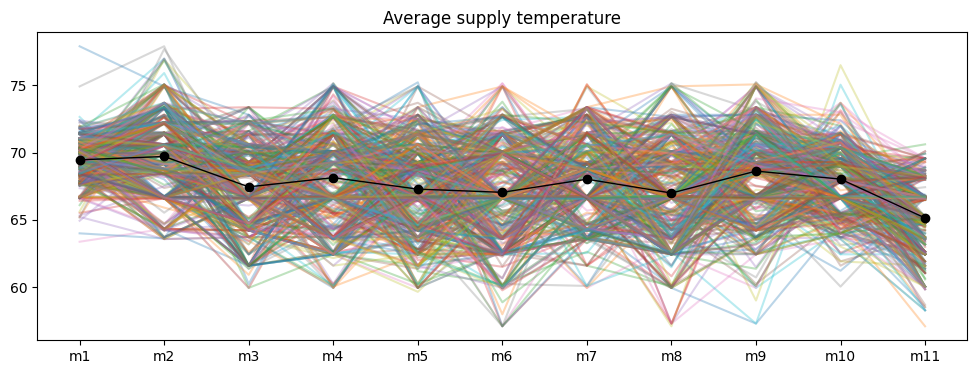

In [496]:
#Visualize average supply temperature
plt.plot(meter_keys, np.array(t_avg), alpha=0.3)
plt.plot(meter_keys, np.mean(np.array(t_avg), axis=1), color='black', linewidth=1, marker='o')
plt.rcParams['figure.figsize'] = [10, 4]
plt.title('Average supply temperature')

In [497]:
#Calculate load, mf, and temperature difference from raw data
Cp = 1.1622 # 4184 J/kg.K = 1.1622 Wh/kg.K
l = np.zeros((len(meter_keys),meter_data['m1'].shape[0]-1))
mf = np.zeros((len(meter_keys),meter_data['m1'].shape[0]-1))
temp_diff = np.zeros((len(meter_keys),meter_data['m1'].shape[0]-1))
for i,meter in enumerate(meter_keys):
    for t in range(1,meter_data[meter].shape[0]-1):
        l[i,t-1] = (meter_data[meter]['cumulative_heat_energy'].values[t]-meter_data[meter]['cumulative_heat_energy'].values[t-1])*1000 #kW/h
        mf[i,t-1] = (meter_data[meter]['cumulative_hot_water_volume'].values[t]-meter_data[meter]['cumulative_hot_water_volume'].values[t-1])*1000 #kg/h
        temp_diff[i,t-1] = l[i,t-1]/((Cp/1000) * mf[i,t-1])

Text(0.5, 1.0, 'Load [kW/h]')

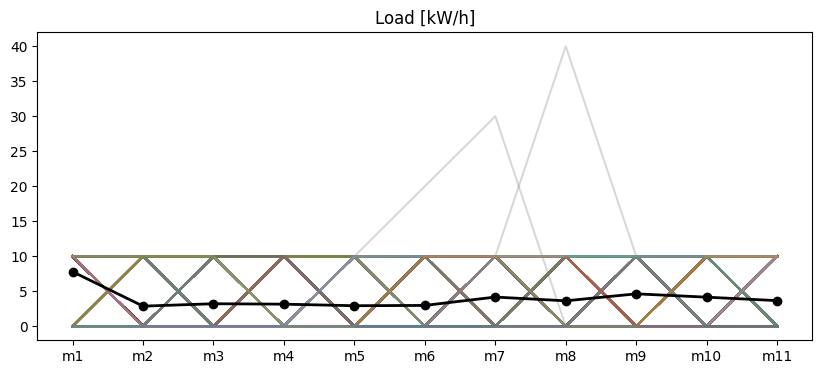

In [498]:
#Visualize load
plt.plot(meter_keys, np.array(l), alpha=0.3)
plt.plot(meter_keys, np.mean(np.array(l), axis=1), color='black', linewidth=2, marker='o')
plt.rcParams['figure.figsize'] = [10, 4]
plt.title('Load [kW/h]')

Text(0.5, 1.0, 'Mass flow [kg/h]')

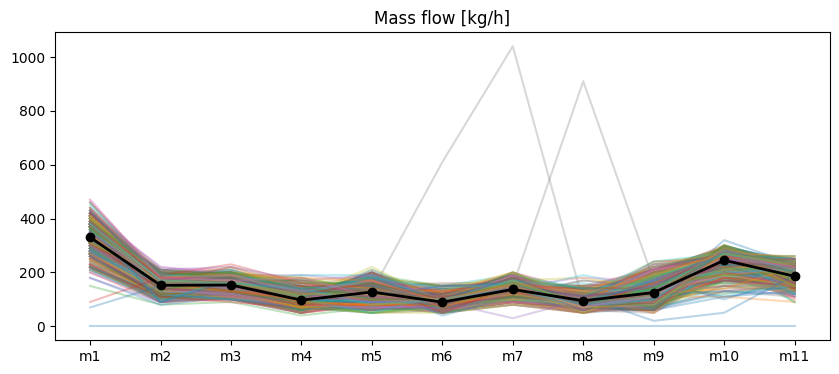

In [499]:
#Visualize mf
plt.plot(meter_keys, np.array(mf), alpha=0.3)
plt.plot(meter_keys, np.mean(np.array(mf), axis=1), color='black', linewidth=2, marker='o')
plt.rcParams['figure.figsize'] = [10, 4]
plt.title('Mass flow [kg/h]')

Text(0.5, 1.0, 'Derived temperature difference')

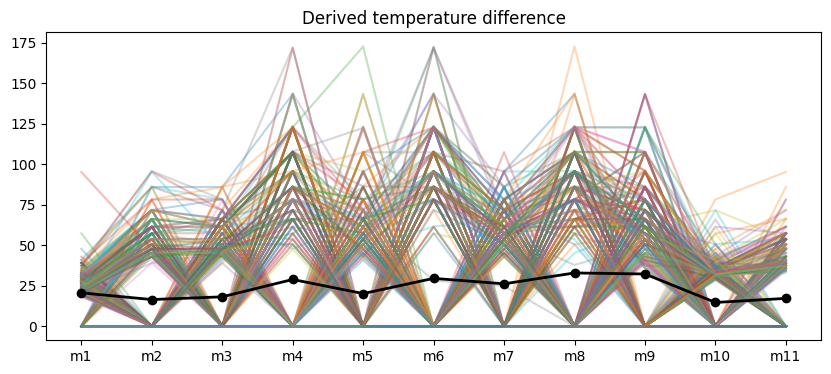

In [500]:
#Visualize temperature difference
plt.plot(meter_keys, np.array(temp_diff), alpha=0.3)
plt.plot(meter_keys, np.mean(np.array(temp_diff), axis=1), color='black', linewidth=2, marker='o')
plt.rcParams['figure.figsize'] = [10, 4]
plt.title('Derived temperature difference')

### Supply temperature at the node accounting for temperature loss in the branch pipeline

In [501]:
#Meter specific branch pipeline data
l = {
'm1' : 350,
'm2' : 170,
'm3' : 150,
'm4' : 36+30,
'm5' : 110,
'm6' : 75,
'm7' : 105,
'm8' : 49,
'm9' : 9,
'm10' : 4,
'm11' : 20
}

r_in = {
'm1' : 32/(2*1000),
'm2' : 16/(2*1000),
'm3' : 32/(2*1000),
'm4' : 32/(2*1000),
'm5' : 16/(2*1000),
'm6' : 16/(2*1000),
'm7' : 16/(2*1000),
'm8' : 16/(2*1000),
'm9' : 10/(2*1000),
'm10' : 10/(2*1000),
'm11' : 12/(2*1000)
}

In [502]:
#Fixed branch pipeline data
T_soil = 10
r_out = 110/(2*1000)
k = 0.025
Cp = 1.1622

for i, meter_no in enumerate(meter_data.keys()):
    T_m = np.array(t_avg)[i,1:-1].mean()
    mf_m = mf[i,:].mean()
    T_n = ((2*np.pi*l[meter_no]*k*(T_m-T_soil))  / (np.log(r_out/r_in[meter_no])*Cp*mf_m)) + T_m
    print(f'T_{meter_no}: ', T_n)

T_m1:  76.36690308632086
T_m2:  74.39025824078762
T_m3:  73.60737335191978
T_m4:  72.46953853619958
T_m5:  70.76709714773642
T_m6:  70.41842779639957
T_m7:  71.15616761233959
T_m8:  69.08145620389558
T_m9:  68.87911030568581
T_m10:  68.0948809834221
T_m11:  65.5124352962434


(50.0, 90.0)

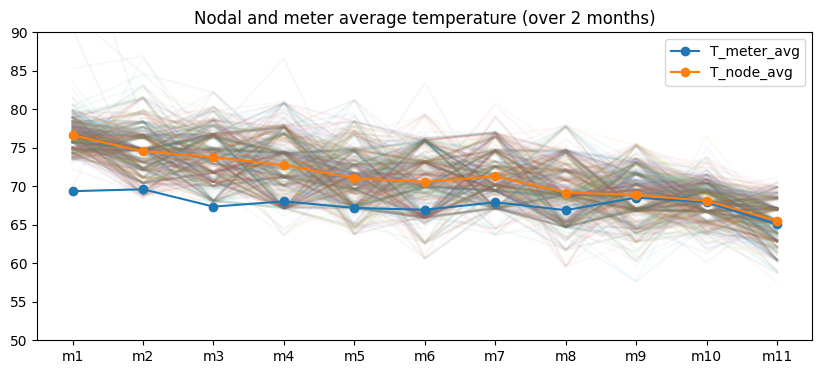

In [503]:
#Visualize the temperature drop
Q_matrix = np.zeros((len(meter_data), set_range-1)) # To remove 1st data point to calculate mf (from cumulative data)
T_meter_matrix = np.zeros((len(meter_data), set_range-1))
T_node_matrix = np.zeros((len(meter_data), set_range-1))

for i, meter_no in enumerate(meter_data.keys()):
    for t in range(1, set_range-1):
        Q_matrix[i, t], T_meter_matrix[i, t], T_node_matrix[i,t] = temp_loss(meter_data, l, r_in, meter_no, t, meter_avg_temp)

T_meter_avg = np.mean(T_meter_matrix, axis=1)
T_node_avg = np.mean(T_node_matrix[:,1:-1], axis=1)
plt.plot(meter_keys, T_node_matrix[:,1:-1], alpha=0.05)
plt.plot(meter_keys, T_meter_avg, 'o-', label='T_meter_avg', color='C0')
plt.plot(meter_keys, T_node_avg, 'o-', label='T_node_avg', color='C1')
plt.rcParams['figure.figsize'] = [12, 4]
plt.title('Nodal and meter average temperature (over 2 months)')
plt.legend()
plt.ylim(50,90)

### Statistical result
For each meter, what is the probability that it is placed in each of the nodes?

In [504]:
#Order and store rankings
rankings = np.zeros(T_node_matrix[:,1:-1].shape)

for i in range(0,T_node_matrix[:,1:-1].shape[1]):
    t = T_node_matrix[:,1:-1][:,i]
    sorted_data = sorted(enumerate(t), key=lambda x: x[1], reverse=True)
    for rank, (index, _) in enumerate(sorted_data):
        rankings[index][i] = rank 

In [505]:
#Calculate probability of each meter in each node
prob = {}
max_prob = {}
for i, m in enumerate(meter_keys):
    prob_m = []
    for j in range(0,len(meter_keys)):
        prob_m.append(list(rankings[i]).count(j))
    prob[m] = np.array(prob_m)/sum(prob_m)
    max_prob[m] = np.argmax(np.array(prob_m))

In [506]:
for m in meter_keys:
    print(f'max prob for meter {m}: ', max_prob[m]+1)

max prob for meter m1:  1
max prob for meter m2:  2
max prob for meter m3:  3
max prob for meter m4:  4
max prob for meter m5:  5
max prob for meter m6:  6
max prob for meter m7:  7
max prob for meter m8:  8
max prob for meter m9:  9
max prob for meter m10:  10
max prob for meter m11:  11


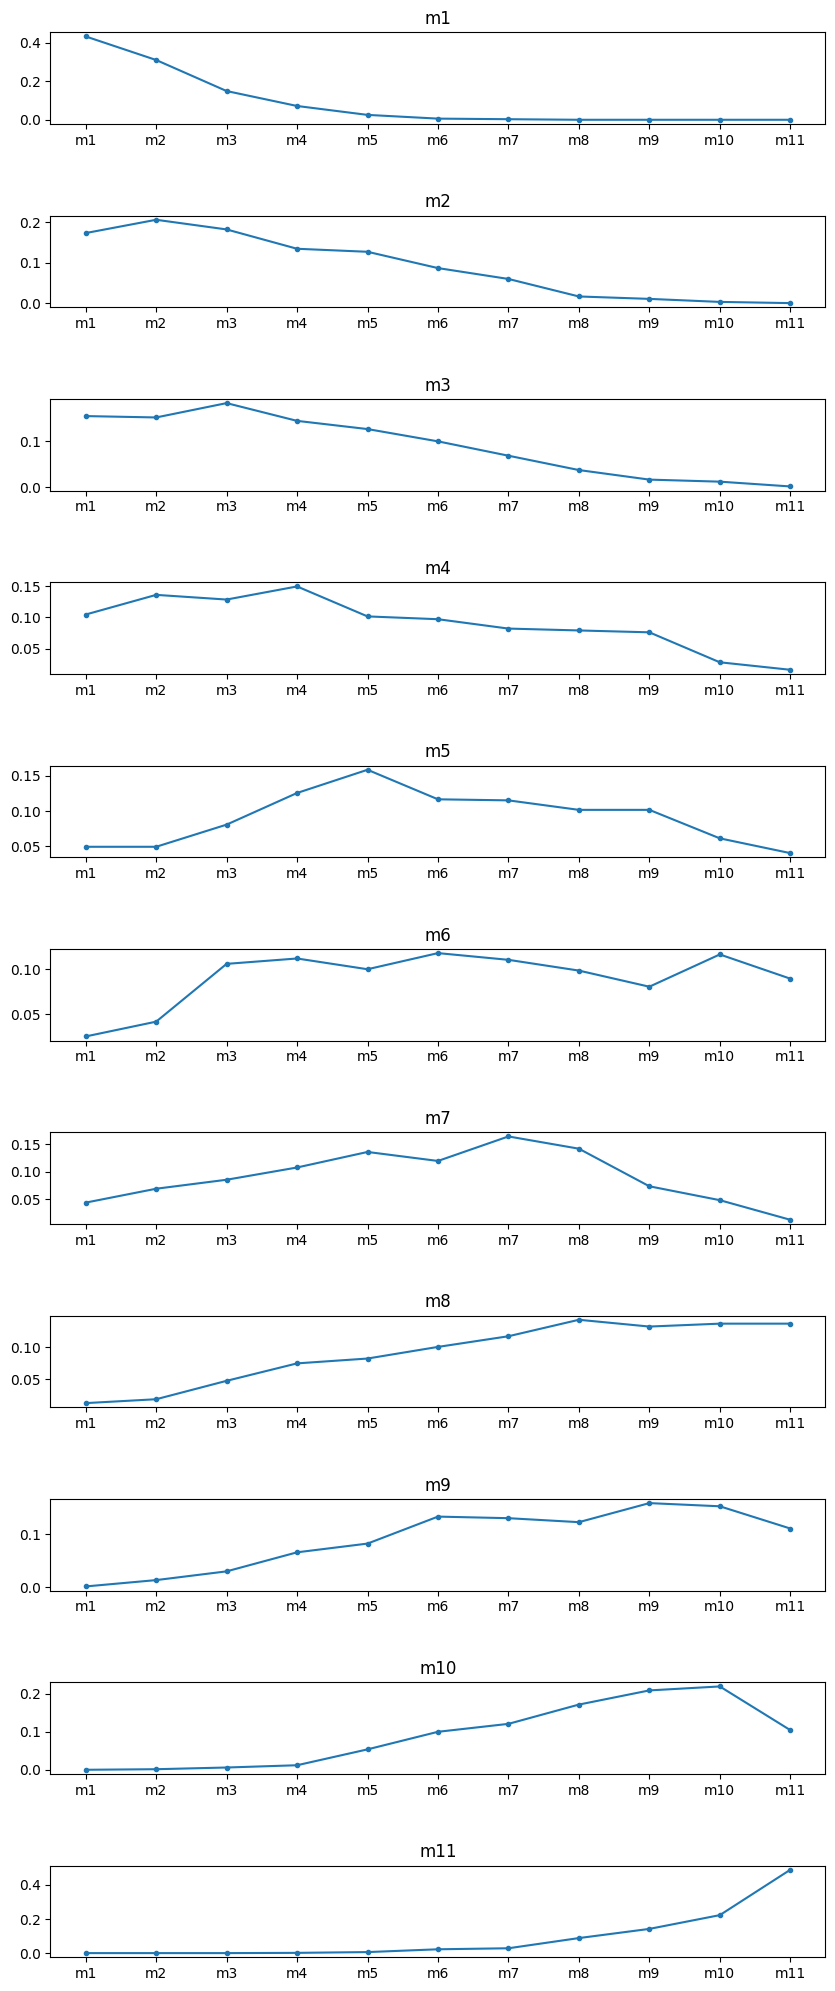

In [507]:
#Visualize probability distribution for each meter in each node
fig, ax = plt.subplots(nrows=len(meter_keys), figsize=(10,25))

for i in range(0,len(meter_keys)):
    ax[i].plot(meter_keys,prob[meter_keys[i]],'.-')
    ax[i].set_title(f'{meter_keys[i]}')
    plt.subplots_adjust(hspace=1)